In [1]:
import pystac_client
import planetary_computer
import fsspec
import xarray as xr

import geopandas as gpd
import numpy as np

import calendar

### ARIDITY INDEX AND REGIONS FUNCTIONS

In [2]:
def mth_end(month,year):
    if month in (1,3,5,7,8,10,12):
        return str(year)+'-'+str(month)+'-31'
    if month in (4,6,9,11):
        return str(year)+'-'+str(month)+'-30'
    if calendar.isleap(year):
        return str(year)+'-02-29'
    return str(year)+'-02-28'

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
def mth_arid_index(month,year,prec,evap):
    m_prec = prec.sel(time=slice(str(year)+'-'+str(month)+'-01',mth_end(month,year)))
    m_evap = evap.sel(time=slice(str(year)+'-'+str(month)+'-01',mth_end(month,year)))
    
    total_prec = m_prec.sum(dim='time')
    total_evap = m_evap.sum(dim='time')
    
    return total_prec/total_evap

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# assumes ca_shp and darray already have same crs
def ca_clip(ds,darray,ca_shp):
    crs = ds.attrs['coordinate_system']
    da_clip = darray.rio.write_crs(crs) 
    return da_clip.rio.clip(ca_shp.geometry, ca_shp.crs)  

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# ds = gridemet dataset
# n = number of years used in averaging 
def aridity_index(ds,year,n,ca_shp):
    
    # ** add stop for date out of range **
    # select full range over which to compute average of monthly aridity indices
    prec = ds["precipitation_amount"].sel(time=slice(str(year-n+1)+'-01-01',str(year)+'-12-31'))
    evap = ds["potential_evapotranspiration"].sel(time=slice(str(year-n+1)+'-01-01',str(year)+'-12-31'))
    
    # clip to CA
    ca_prec = ca_clip(ds,prec,ca_shp)
    ca_evap = ca_clip(ds,evap,ca_shp)
    
    stack = xr.DataArray()
    stack = stack.astype('float32') 
    for i in range(1,13):
        for j in range(year-n+1,year+1):
            month_ai = mth_arid_index(i,j,ca_prec,ca_evap)
            # *** OPTIMIZE THIS WITHOUT xr.concat ***
            stack = xr.concat([stack,month_ai], dim='time', combine_attrs='drop')

    # drop first layer (empty dataarray)
    stack = stack.sel(time=slice(1,12*n+1))
    ai = stack.mean(dim='time')
    
    #set CRS
    ai.rio.set_crs(ds.attrs['coordinate_system'])
    
    # update attributes
    ai.attrs['long_name']='California '+str(year)+' Aridity Index as Average of Monthly Aridity Indices '+str(year-n+1)+'-'+str(year)
    ai.attrs['coordinate_system']=ds.attrs['coordinate_system']
    ai.attrs['year']=str(year)
    ai.attrs['start_month']='1-'+str(year-n+1)
    ai.attrs['end_month']='12-'+str(year)
    
    return ai

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------

def arid_regions(arid):
    # extract numpy.ndarray
    ai_rgns = arid.to_numpy()
    
    # establish thresholds
    k = [0.05,0.65]
    
    # group into regions
    ai_rgns[np.where(k[1]<=ai_rgns)] = 3
    ai_rgns[np.where( ai_rgns< k[0])] = 1
    ai_rgns[np.where( (k[0]<=ai_rgns) & (ai_rgns<k[1]))] = 2
    
    # create xarray.DataArray with np.ndarray
    ai_regions = xr.DataArray(
        data= ai_rgns,
        dims= arid.dims,
        coords= arid.coords
    )
    
    # reduce data type and update nodata?
    #ai_regions = ai_regions.astype('uint8')
    #ai_regions.rio.write_nodata(0, inplace=True)
    
    #set CRS
    ai_regions.rio.set_crs(arid.attrs['coordinate_system'])
    
    # update attributes
    ai_regions.attrs['long_name'] = 'California Moisture Domains Based on '+arid.attrs['year']+' 2020 Aridity Index'
    ai_regions.attrs['coordinate_system']=arid.attrs['coordinate_system']
    ai_regions.attrs['year']=arid.attrs['year']

#    ai_regions.attrs['nodata_value']=0
    ai_regions.attrs['code_1']= 'Desert (Hyperarid): aridity index less than '+str(k[0])
    ai_regions.attrs['code_2']= 'Dry (Arid): aridity index in ['+str(k[0])+','+str(k[1])+')'
    ai_regions.attrs['code_3']= 'Moist (Humid): aridity index geq than '+str(k[1])
    
    return ai_regions

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
def aridity_index_n_regions(ds,year,n,ca_shp):
    
    arid = aridity_index(ds,year,n,ca_shp)
    ai_regions = arid_regions(arid)
    
    info = { 'long_name': 'CA Aridity Index and Moisture Domains ('+arid.attrs['year']+')',
         'year' : arid.attrs['year'],
         'about_data' : 'generated using daily gridMET dataset, accessed through Microsoft Planetary Computer',
         'author' : 'C. Galaz García'
       }
    arid_info = xr.Dataset(attrs = info)
    # *** this can most likely be done together with prev step**
    arid_info = arid_info.assign(aridity_index = arid, 
                                 aridity_regions = ai_regions)
    return arid_info

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
def arid_rgns_increase(recent, past):
    increase = past-recent # 1 = more arid, 3 = less arid
    increase = increase.where(increase>0)
    
    increase.attrs['long_name'] = 'Transition to More Arid Moisture Domain ('+str(past.attrs['year'])+'-'+str(recent.attrs['year']+')')
    increase.attrs['years_compared'] = (past.attrs['year'],recent.attrs['year'])
    
    # update crs (already has crs coord from recent & past)
    increase.attrs['coordinate_system']=recent.attrs['coordinate_system']
    increase.rio.set_crs(recent.attrs['coordinate_system'])
    
    return increase

## LOAD GRIDMET DATA FOR TRIALS

In [3]:
# --------------------------------------------------------------------------
# LOAD GRIDMET DATASET

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
gridmet = catalog.get_collection("gridmet")
asset = planetary_computer.sign(gridmet.assets["zarr-abfs"])

store = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

# --------------------------------------------------------------------------
# LOAD CA SHAPEFILE AND MATCH WITH DS CRS

# extract crs from xarray.DataArray
crs= ds.attrs['coordinate_system']

# import shapefile
ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

# match CRS
ca_shp = ca_shape.to_crs(ds.attrs['coordinate_system'])

## TRIALS

In [4]:
trial = aridity_index(ds,2020,1,ca_shp) 
trial

<xarray.DataArray (lat: 227, lon: 249)>
dask.array<mean_agg-aggregate, shape=(227, 249), dtype=float32, chunksize=(227, 249), chunktype=numpy.ndarray>
Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
Attributes:
    long_name:          California 2020 Aridity Index as Average of Monthly A...
    coordinate_system:  EPSG:4326
    year:               2020
    start_month:        1-2020
    end_month:          12-2020

In [5]:
print('current crs: ', trial.rio.crs, '\n')
print('current coords: ', trial.coords, '\n')
print('current attrs: ',[*trial.attrs])

current crs:  EPSG:4326 

current coords:  Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 

current attrs:  ['long_name', 'coordinate_system', 'year', 'start_month', 'end_month']


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


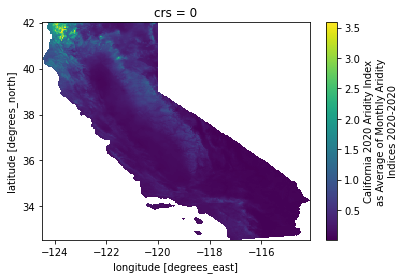

In [6]:
trial.plot()

In [7]:
trial_regions = arid_regions(trial)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [8]:
print('current crs: ', trial_regions.rio.crs, '\n')
print('current coords: ', trial_regions.coords, '\n')
print('current attrs: ',[*trial_regions.attrs])

current crs:  EPSG:4326 

current coords:  Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 

current attrs:  ['long_name', 'coordinate_system', 'year', 'code_1', 'code_2', 'code_3']


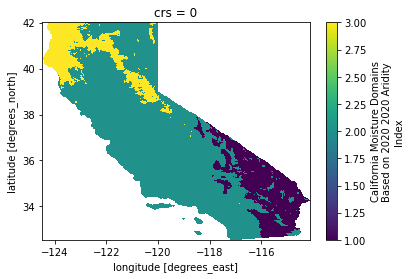

In [9]:
trial_regions.plot()

### COMPARING WITH ARIDITY INDEX AND REGIONS GENERATED IN TRIALS

In [10]:
# open previously computed AI
fp = "/home/jovyan/aridity_layer/ca_aridity2020.nc"
check = xr.open_dataset(fp)

# check difference in values
diff = check['aridity_index'] - trial
diff = diff.to_numpy()
diff = diff[~np.isnan(diff)]  # remove nan
print(np.unique(diff))

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[0.]


In [11]:
diff = check['aridity_regions'] - trial_regions
diff = diff.to_numpy()
diff = diff[~np.isnan(diff)]  # remove nan
print(np.unique(diff))

[0.]


### ARIDITY AND REGIONS IN SAME xarray.Dataset

In [12]:
aridity_index_n_regions(ds,2020,1,ca_shp)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:          (lat: 227, lon: 249)
Coordinates:
    crs              int64 0
  * lat              (lat) float64 41.98 41.94 41.9 41.86 ... 32.65 32.61 32.57
  * lon              (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
Data variables:
    aridity_index    (lat, lon) float32 dask.array<chunksize=(227, 249), meta=np.ndarray>
    aridity_regions  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:   CA Aridity Index and Moisture Domains (2020)
    year:        2020
    about_data:  generated using daily gridMET dataset, accessed through Micr...
    author:      C. Galaz García

### ARIDITY INCREASE REGIONS

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


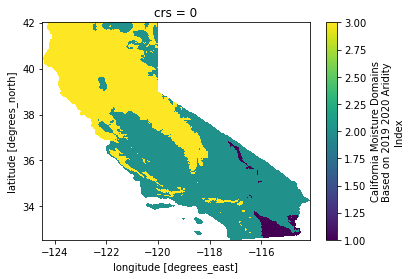

In [13]:
trial19 = arid_regions(aridity_index(ds,2019,20,ca_shp))
trial19.plot()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


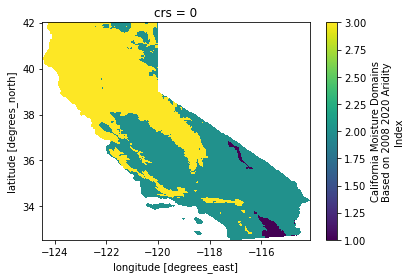

In [14]:
trial08 = arid_regions(aridity_index(ds,2008,20,ca_shp))
trial08.plot()

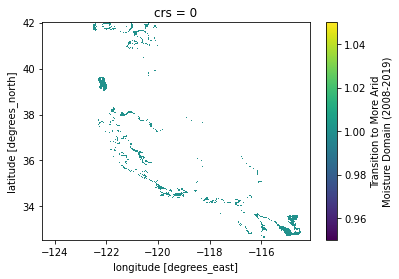

In [15]:
trial_diff = arid_rgns_increase(recent=trial19,past=trial08)
trial_diff.plot()

In [18]:
print('current crs: ', trial_diff.rio.crs, '\n')
print('current coords: ', trial_diff.coords, '\n')
print('current attrs: ',[*trial_diff.attrs])
trial_diff

current crs:  EPSG:4326 

current coords:  Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 

current attrs:  ['long_name', 'years_compared', 'coordinate_system']


<xarray.DataArray (lat: 227, lon: 249)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
Attributes:
    long_name:          Transition to More Arid Moisture Domain (2008-2019)
    years_compared:     ('2008', '2019')
    coordinate_system:  EPSG:4326

### EXPORT REGIONS

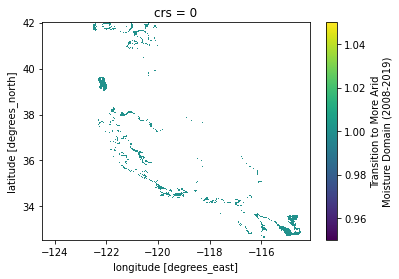

In [25]:
#https://xarray.pydata.org/en/stable/user-guide/io.html
outfp = "/home/jovyan/aridity_layer/arid_increase_2008_2019.nc"
trial_diff.to_netcdf(outfp)

check = xr.open_dataarray(outfp)
check.plot()

In [26]:
check

<xarray.DataArray (lat: 227, lon: 249)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    crs      int64 ...
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
Attributes:
    long_name:          Transition to More Arid Moisture Domain (2008-2019)
    years_compared:     ['2008', '2019']
    coordinate_system:  EPSG:4326

In [27]:
print('current crs: ', check.rio._crs, '\n')
# *** WHY DOES THIS NOT GET SAVED? ***

current crs:  None 

